In [1]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Capstone/lib')

import pandas as pd
import numpy as np
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

df = pd.read_csv('data/play_data2.csv')

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = df[:50]#only labeled 50 records
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(columns=['Unnamed: 0.1'])
df.tail()

,segment,review_id,product_name,producturl,retailer,brand,retailer_product_id,base_id,variants_flag,review_creation_date,year,month,week,review_title,review_text,review_type,price,rating,images,videos,helpful_votes,promotion_flag,review_lower,date,word_count,price2,time,effectiveness,ease of use
45,Garden,142830,Smart Seed Kentucky Bluegrass Blend 3lb bag,http://www.homedepot.com/p/314933301,Homedepot,Pennington Grass,314933309,314933301,Yes,2022-06-02T00:00:00,2022,6,22,Soak,I strongly recommend pregermination! Ive tried...,organic reviews,19.48,4,1,0,0,No,i strongly recommend pregermination! ive tried...,6/2/2022,47,1.0,1.0,1.0,NaN
46,Garden,22968,Ironite Mineral Supplement 1-0-1 by Pennington...,http://www.homedepot.com/p/t/205561089,Homedepot,Pennington Fertilizer,205561089,205561089,Yes,2021-06-09T00:00:00,2021,6,23,Ive used this product before and have had grea...,Ive used this product before and have had great,organic reviews,18.98,5,0,0,0,No,ive used this product before and have had great,6/9/2021,9,NaN,NaN,1.0,NaN
47,Garden,132073,Sevin Insect Killer,http://www.homedepot.com/p/303593722,Homedepot,GardenTech,100598614,303593722,Yes,2022-05-30T00:00:00,2022,5,22,Protect your garden,[This review was collected as part of a promot...,syndicated reviews,7.49,5,0,0,0,Yes,[this review was collected as part of a promot...,5/30/2022,34,NaN,1.0,1.0,NaN
48,Garden,135534,"Pennington Smart Patch Bermudagrass Mix, 5 lb Jug",https://www.lowes.com/pd/Pennington-Smart-Patc...,Lowes,Pennington Grass,5005478639,5005478639,No,2022-05-14T00:00:00,2022,5,19,Pennington patch,[This review was collected as part of a promot...,syndicated reviews,11.98,4,0,0,0,Yes,[this review was collected as part of a promot...,5/14/2022,66,NaN,1.0,1.0,1.0
49,Garden,110439,"Pennington Smart Patch Tall Fescue Mix, 30 lb",http://www.homedepot.com/p/317713416,Homedepot,Pennington Grass,317713427,317713416,Yes,2022-04-28T00:00:00,2022,4,17,No results yet,"So far, no growth. Think I applied to early in...",organic reviews,0.00,3,4,0,0,No,"so far, no growth. think i applied to early in...",4/28/2022,204,NaN,1.0,1.0,NaN


In [3]:
#replace NaN in label columns with 0
columns = ['price2','time', 'effectiveness', 'ease of use']

for column in columns:
    df[column] = df[column].replace(np.nan, int(0))

#extract column "review_lower" and label columns for tuning
df = df[['review_lower','price2','time', 'effectiveness', 'ease of use' ]]

In [4]:
#train/val/test split
df_train = df.iloc[:30]
df_val = df.iloc[30:40]
df_test = df.iloc[40:]

df_train.to_csv("data/train_labels.csv", index=False)
df_val.to_csv("data/val_labels.csv", index=False)
df_test.to_csv("data/test_labels.csv", index=False)

In [5]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files={"train": "data/train_labels.csv", "val": "data/val_labels.csv", "test": "data/test_labels.csv"})

Using custom data configuration default-1c2f666fc2aa84bc


Extracting data files: 100%|██████████| 3/3 [00:00<00:00, 596.32it/s]


Dataset csv downloaded and prepared to C:/Users/Woon/.cache/huggingface/datasets/csv/default-1c2f666fc2aa84bc/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 428.22it/s]


In [6]:
from transformers import BartTokenizer

labels = ['price2','time', 'effectiveness', 'ease of use']
       
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-mnli")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["review_lower"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

#encode dataset
encoded_datasets = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

100%|██████████| 1/1 [00:00<00:00, 108.27ba/s]


# Trainer

In [7]:
from transformers import BartForSequenceClassification

#define the model
model = BartForSequenceClassification.from_pretrained("facebook/bart-large-mnli",problem_type="multi_label_classification", num_labels=4, ignore_mismatched_sizes=True)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large-mnli and are newly initialized because the shapes did not match:
- classification_head.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([4, 1024]) in the model instantiated
- classification_head.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Hyperparameters

In [8]:
#declare training hyperparameters
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="lib/Model",
    learning_rate=1e-4,
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.01,
    metric_for_best_model="accuracy",
    # save_strategy="epoch",
    # load_best_model_at_end=True
)

## Metrics

In [9]:
#define a compute_metrics function that returns a dictionary with the desired metric values
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

def multi_label_metrics(predictions, labels, threshold=0.5):
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions))
  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs >= threshold)] = 1
  y_true = labels
  f1_micro_average = f1_score(y_true, y_pred, average="weighted") 
  roc_auc = roc_auc_score(y_true, y_pred, average="micro") 
  accuracy = accuracy_score(y_true, y_pred)

  metrics = {"f1": f1_micro_average,
             "roc_auc": roc_auc,
             "accuracy": accuracy}
  return metrics

def compute_metrics(p: EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  result = multi_label_metrics(predictions=preds, labels=p.label_ids)
  return result

In [10]:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis = -1)
#     return metric.compute(predictions=predictions, references=labels)

# Trainer

In [11]:
#trainer
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = encoded_datasets["train"],
    eval_dataset = encoded_datasets["val"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

trainer.train()

***** Running training *****
  Num examples = 30
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 120
  3%|▎         | 4/120 [01:02<28:16, 14.62s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

  3%|▎         | 4/120 [01:09<28:16, 14.62s/it]

{'eval_loss': 0.4969639182090759, 'eval_f1': 0.568421052631579, 'eval_roc_auc': 0.78, 'eval_accuracy': 0.4, 'eval_runtime': 6.595, 'eval_samples_per_second': 1.516, 'eval_steps_per_second': 0.303, 'epoch': 1.0}


  7%|▋         | 8/120 [02:09<29:01, 15.55s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

  7%|▋         | 8/120 [02:16<29:01, 15.55s/it]

{'eval_loss': 0.5248891115188599, 'eval_f1': 0.6350877192982457, 'eval_roc_auc': 0.7666666666666667, 'eval_accuracy': 0.4, 'eval_runtime': 7.4702, 'eval_samples_per_second': 1.339, 'eval_steps_per_second': 0.268, 'epoch': 2.0}


 10%|█         | 12/120 [03:27<31:42, 17.62s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 10%|█         | 12/120 [03:36<31:42, 17.62s/it]

{'eval_loss': 0.4907119870185852, 'eval_f1': 0.568421052631579, 'eval_roc_auc': 0.7600000000000001, 'eval_accuracy': 0.3, 'eval_runtime': 8.3691, 'eval_samples_per_second': 1.195, 'eval_steps_per_second': 0.239, 'epoch': 3.0}


 13%|█▎        | 16/120 [04:51<32:54, 18.98s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 13%|█▎        | 16/120 [04:59<32:54, 18.98s/it]

{'eval_loss': 0.6233554482460022, 'eval_f1': 0.5666666666666667, 'eval_roc_auc': 0.6599999999999999, 'eval_accuracy': 0.2, 'eval_runtime': 8.4423, 'eval_samples_per_second': 1.185, 'eval_steps_per_second': 0.237, 'epoch': 4.0}


 17%|█▋        | 20/120 [06:33<38:28, 23.09s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 17%|█▋        | 20/120 [06:43<38:28, 23.09s/it]

{'eval_loss': 0.7954081296920776, 'eval_f1': 0.6755555555555557, 'eval_roc_auc': 0.7066666666666666, 'eval_accuracy': 0.2, 'eval_runtime': 10.7057, 'eval_samples_per_second': 0.934, 'eval_steps_per_second': 0.187, 'epoch': 5.0}


 20%|██        | 24/120 [08:19<38:44, 24.21s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 20%|██        | 24/120 [08:30<38:44, 24.21s/it]

{'eval_loss': 0.6825538873672485, 'eval_f1': 0.6666666666666666, 'eval_roc_auc': 0.7333333333333333, 'eval_accuracy': 0.2, 'eval_runtime': 11.1083, 'eval_samples_per_second': 0.9, 'eval_steps_per_second': 0.18, 'epoch': 6.0}


 23%|██▎       | 28/120 [10:04<37:03, 24.17s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 23%|██▎       | 28/120 [10:15<37:03, 24.17s/it]

{'eval_loss': 0.6963640451431274, 'eval_f1': 0.7422222222222222, 'eval_roc_auc': 0.76, 'eval_accuracy': 0.5, 'eval_runtime': 10.8694, 'eval_samples_per_second': 0.92, 'eval_steps_per_second': 0.184, 'epoch': 7.0}


 27%|██▋       | 32/120 [11:49<35:50, 24.44s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 27%|██▋       | 32/120 [12:00<35:50, 24.44s/it]

{'eval_loss': 0.6798157691955566, 'eval_f1': 0.6128654970760234, 'eval_roc_auc': 0.7333333333333333, 'eval_accuracy': 0.2, 'eval_runtime': 10.377, 'eval_samples_per_second': 0.964, 'eval_steps_per_second': 0.193, 'epoch': 8.0}


 30%|███       | 36/120 [13:35<34:06, 24.37s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 30%|███       | 36/120 [13:45<34:06, 24.37s/it]

{'eval_loss': 0.7310382723808289, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7200000000000001, 'eval_accuracy': 0.3, 'eval_runtime': 10.3342, 'eval_samples_per_second': 0.968, 'eval_steps_per_second': 0.194, 'epoch': 9.0}


 33%|███▎      | 40/120 [15:19<32:06, 24.08s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 33%|███▎      | 40/120 [15:30<32:06, 24.08s/it]

{'eval_loss': 0.7297216653823853, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.2, 'eval_runtime': 10.9101, 'eval_samples_per_second': 0.917, 'eval_steps_per_second': 0.183, 'epoch': 10.0}


 37%|███▋      | 44/120 [17:02<29:57, 23.65s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 37%|███▋      | 44/120 [17:13<29:57, 23.65s/it]

{'eval_loss': 0.7401111721992493, 'eval_f1': 0.5866666666666667, 'eval_roc_auc': 0.7200000000000001, 'eval_accuracy': 0.3, 'eval_runtime': 11.4847, 'eval_samples_per_second': 0.871, 'eval_steps_per_second': 0.174, 'epoch': 11.0}


 40%|████      | 48/120 [18:48<29:13, 24.36s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 40%|████      | 48/120 [18:59<29:13, 24.36s/it]

{'eval_loss': 0.8251039385795593, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.68, 'eval_accuracy': 0.3, 'eval_runtime': 10.5227, 'eval_samples_per_second': 0.95, 'eval_steps_per_second': 0.19, 'epoch': 12.0}


 43%|████▎     | 52/120 [20:33<27:34, 24.33s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 43%|████▎     | 52/120 [20:43<27:34, 24.33s/it]

{'eval_loss': 0.884296715259552, 'eval_f1': 0.5666666666666667, 'eval_roc_auc': 0.6599999999999999, 'eval_accuracy': 0.2, 'eval_runtime': 10.0741, 'eval_samples_per_second': 0.993, 'eval_steps_per_second': 0.199, 'epoch': 13.0}


 47%|████▋     | 56/120 [22:20<26:32, 24.88s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 47%|████▋     | 56/120 [22:32<26:32, 24.88s/it]

{'eval_loss': 0.8338438868522644, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 12.1706, 'eval_samples_per_second': 0.822, 'eval_steps_per_second': 0.164, 'epoch': 14.0}


 50%|█████     | 60/120 [24:20<27:02, 27.05s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 50%|█████     | 60/120 [24:33<27:02, 27.05s/it]

{'eval_loss': 0.8093273043632507, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 13.3546, 'eval_samples_per_second': 0.749, 'eval_steps_per_second': 0.15, 'epoch': 15.0}


 53%|█████▎    | 64/120 [26:07<23:40, 25.37s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 53%|█████▎    | 64/120 [26:20<23:40, 25.37s/it]

{'eval_loss': 0.8207457661628723, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 12.5412, 'eval_samples_per_second': 0.797, 'eval_steps_per_second': 0.159, 'epoch': 16.0}


 57%|█████▋    | 68/120 [27:50<20:08, 23.24s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 57%|█████▋    | 68/120 [27:59<20:08, 23.24s/it]

{'eval_loss': 0.8544920682907104, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 9.1839, 'eval_samples_per_second': 1.089, 'eval_steps_per_second': 0.218, 'epoch': 17.0}


 60%|██████    | 72/120 [29:13<16:08, 20.17s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 60%|██████    | 72/120 [29:22<16:08, 20.17s/it]

{'eval_loss': 0.872890830039978, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.4764, 'eval_samples_per_second': 1.18, 'eval_steps_per_second': 0.236, 'epoch': 18.0}


 63%|██████▎   | 76/120 [30:33<13:43, 18.72s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 63%|██████▎   | 76/120 [30:41<13:43, 18.72s/it]

{'eval_loss': 0.860338568687439, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.5345, 'eval_samples_per_second': 1.172, 'eval_steps_per_second': 0.234, 'epoch': 19.0}


 67%|██████▋   | 80/120 [31:53<12:24, 18.62s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 67%|██████▋   | 80/120 [32:03<12:24, 18.62s/it]

{'eval_loss': 0.8567285537719727, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 10.1372, 'eval_samples_per_second': 0.986, 'eval_steps_per_second': 0.197, 'epoch': 20.0}


 70%|███████   | 84/120 [33:23<12:13, 20.37s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 70%|███████   | 84/120 [33:33<12:13, 20.37s/it]

{'eval_loss': 0.8565300703048706, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 9.7266, 'eval_samples_per_second': 1.028, 'eval_steps_per_second': 0.206, 'epoch': 21.0}


 73%|███████▎  | 88/120 [34:53<10:50, 20.33s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 73%|███████▎  | 88/120 [35:02<10:50, 20.33s/it]

{'eval_loss': 0.8612947463989258, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.9519, 'eval_samples_per_second': 1.117, 'eval_steps_per_second': 0.223, 'epoch': 22.0}


 77%|███████▋  | 92/120 [36:15<08:53, 19.07s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 77%|███████▋  | 92/120 [36:23<08:53, 19.07s/it]

{'eval_loss': 0.8703070878982544, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.4962, 'eval_samples_per_second': 1.177, 'eval_steps_per_second': 0.235, 'epoch': 23.0}


 80%|████████  | 96/120 [37:37<07:38, 19.12s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 80%|████████  | 96/120 [37:46<07:38, 19.12s/it]

{'eval_loss': 0.8783812522888184, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.4348, 'eval_samples_per_second': 1.186, 'eval_steps_per_second': 0.237, 'epoch': 24.0}


 83%|████████▎ | 100/120 [38:59<06:16, 18.85s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 83%|████████▎ | 100/120 [39:08<06:16, 18.85s/it]

{'eval_loss': 0.8858643770217896, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.568, 'eval_samples_per_second': 1.167, 'eval_steps_per_second': 0.233, 'epoch': 25.0}


 87%|████████▋ | 104/120 [40:20<04:59, 18.72s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 87%|████████▋ | 104/120 [40:28<04:59, 18.72s/it]

{'eval_loss': 0.892125129699707, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.4229, 'eval_samples_per_second': 1.187, 'eval_steps_per_second': 0.237, 'epoch': 26.0}


 90%|█████████ | 108/120 [41:40<03:43, 18.60s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 90%|█████████ | 108/120 [41:49<03:43, 18.60s/it]

{'eval_loss': 0.8965113759040833, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.4663, 'eval_samples_per_second': 1.181, 'eval_steps_per_second': 0.236, 'epoch': 27.0}


 93%|█████████▎| 112/120 [43:02<02:30, 18.85s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 93%|█████████▎| 112/120 [43:10<02:30, 18.85s/it]

{'eval_loss': 0.8987855911254883, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.5236, 'eval_samples_per_second': 1.173, 'eval_steps_per_second': 0.235, 'epoch': 28.0}


 97%|█████████▋| 116/120 [44:23<01:14, 18.68s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

 97%|█████████▋| 116/120 [44:31<01:14, 18.68s/it]

{'eval_loss': 0.899310290813446, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.5012, 'eval_samples_per_second': 1.176, 'eval_steps_per_second': 0.235, 'epoch': 29.0}


100%|██████████| 120/120 [45:44<00:00, 18.65s/it]***** Running Evaluation *****
  Num examples = 10
  Batch size = 8

100%|██████████| 120/120 [45:52<00:00, 18.65s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 120/120 [45:52<00:00, 22.94s/it]

{'eval_loss': 0.8993501663208008, 'eval_f1': 0.5777777777777777, 'eval_roc_auc': 0.7000000000000002, 'eval_accuracy': 0.3, 'eval_runtime': 8.5534, 'eval_samples_per_second': 1.169, 'eval_steps_per_second': 0.234, 'epoch': 30.0}
{'train_runtime': 2752.8836, 'train_samples_per_second': 0.327, 'train_steps_per_second': 0.044, 'train_loss': 0.06108439763387044, 'epoch': 30.0}


TrainOutput(global_step=120, training_loss=0.06108439763387044, metrics={'train_runtime': 2752.8836, 'train_samples_per_second': 0.327, 'train_steps_per_second': 0.044, 'train_loss': 0.06108439763387044, 'epoch': 30.0})

In [12]:
trainer.save_model("lib/Model/")#save the model

Saving model checkpoint to lib/Model/
Configuration saved in lib/Model/config.json
Model weights saved in lib/Model/pytorch_model.bin
tokenizer config file saved in lib/Model/tokenizer_config.json
Special tokens file saved in lib/Model/special_tokens_map.json


In [13]:
df_test = pd.read_csv("data/play_data2.csv")
df_test = df_test[["review_lower"]]

In [14]:
#Load the fine-tuned BART model
from transformers import BartForSequenceClassification

model = BartForSequenceClassification.from_pretrained("lib/Model", problem_type="multi_label_classification", num_labels=4)

loading configuration file lib/Model\config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3'}. The number of labels wil be overwritten to 4.
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-mnli",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
   

In [15]:
#Load the tokenizer
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("lib/Model")

Didn't find file lib/Model\added_tokens.json. We won't load it.
loading file lib/Model\vocab.json
loading file lib/Model\merges.txt
loading file None
loading file lib/Model\special_tokens_map.json
loading file lib/Model\tokenizer_config.json


In [16]:
import torch

price = []
time = []
effectiveness = []
ease_of_use = []

for i in range(len(df_test["review_lower"])):
  text = df_test["review_lower"][i]
  encoding = tokenizer(text, return_tensors="pt")
  encoding = {k: v.to(model.device) for k,v in encoding.items()}
  outputs = model(**encoding)

  #apply sigmoid and threshold
  sigmoid = torch.nn.Sigmoid()
  logits = outputs.logits
  probs = sigmoid(logits.squeeze().cpu())

  price.append(probs[0].detach().numpy())
  time.append(probs[1].detach().numpy())
  effectiveness.append(probs[2].detach().numpy())
  ease_of_use.append(probs[3].detach().numpy())


In [17]:
df_test["price"] = price
df_test["time"] = time
df_test["effectiveness"] = effectiveness
df_test["ease_of_use"] = ease_of_use

df_test.head()

,review_lower,price,time,effectiveness,ease_of_use
0,this grass seed is excellent.,0.003350016,0.0030852596,0.0020375329,0.0024944132
1,its bird food and the birds ate it...two thumb...,0.0013283715,0.0013316687,0.9990094,0.0013169522
2,i am very happy with the results. i removed th...,0.0013474321,0.9990331,0.9987901,0.0011611793
3,i am a big fan of pennington bird seeds. i som...,0.0012460023,0.0014329794,0.99867886,0.9988525
4,came in convenient size bag. only problem the ...,0.0020240732,0.0011155434,0.9986016,0.9987431


In [18]:
df_test.to_csv('data/few_shot_output.csv')

In [19]:
df_demo = pd.read_csv('data/few_shot_output.csv')

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

[Text(0, 0, '88'),
 Text(0, 0, '96'),
 Text(0, 0, '73'),
 Text(0, 0, '43'),
 Text(0, 0, '26'),
 Text(0, 0, '18'),
 Text(0, 0, '9'),
 Text(0, 0, '12'),
 Text(0, 0, '10'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '7'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 T

0.004629629629629629

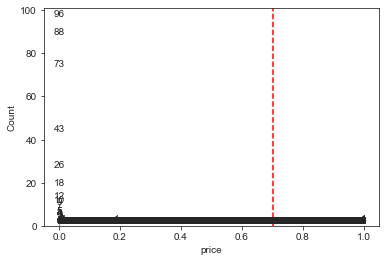

In [21]:
sns.set_style('ticks');
fig, ax = plt.subplots();
ax = sns.histplot(x = 'price', data = df_demo);
plt.axvline(0.7, 0,700, c = 'r', ls = '--');
for container in ax.containers:
    ax.bar_label(container);

len(df_demo[df_demo['price'] > 0.7])/len(df_demo['price'])
#subcategories of quality. may be too broad



[Text(0, 0, '223'),
 Text(0, 0, '37'),
 Text(0, 0, '15'),
 Text(0, 0, '10'),
 Text(0, 0, '17'),
 Text(0, 0, '8'),
 Text(0, 0, '16'),
 Text(0, 0, '15'),
 Text(0, 0, '23'),
 Text(0, 0, '68')]

0.24537037037037038

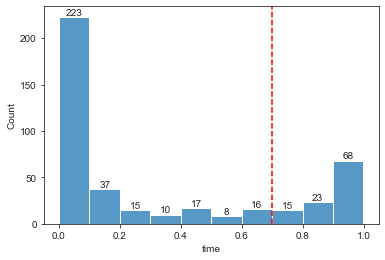

In [22]:
sns.set_style('ticks');
fig, ax = plt.subplots();
ax = sns.histplot(x = 'time', data = df_demo);
plt.axvline(0.7, 0,700, c = 'r', ls = '--');
for container in ax.containers:
    ax.bar_label(container);

len(df_demo[df_demo['time'] > 0.7])/len(df_demo['time'])



[Text(0, 0, '5'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0

0.9375

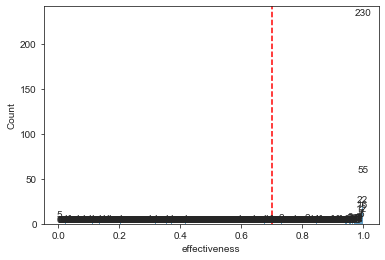

In [23]:
sns.set_style('ticks');
fig, ax = plt.subplots();
ax = sns.histplot(x = 'effectiveness', data = df_demo);
plt.axvline(0.7, 0,700, c = 'r', ls = '--');
for container in ax.containers:
    ax.bar_label(container);

len(df_demo[df_demo['effectiveness'] > 0.7])/len(df_demo['effectiveness'])

[Text(0, 0, '213'),
 Text(0, 0, '20'),
 Text(0, 0, '13'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '11'),
 Text(0, 0, '18'),
 Text(0, 0, '9'),
 Text(0, 0, '20'),
 Text(0, 0, '87')]

0.26851851851851855

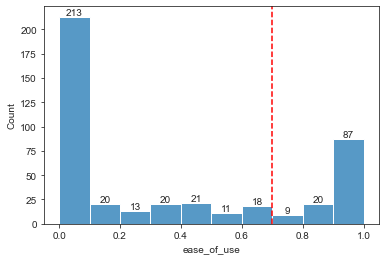

In [24]:
sns.set_style('ticks');
fig, ax = plt.subplots();
ax = sns.histplot(x = 'ease_of_use', data = df_demo);
plt.axvline(0.7, 0,700, c = 'r', ls = '--');
for container in ax.containers:
    ax.bar_label(container);

len(df_demo[df_demo['ease_of_use'] > 0.7])/len(df_demo['ease_of_use'])

In [26]:
df_uncat = df_demo[df_demo['price'] < 0.7]
df_uncat = df_uncat[df_uncat['time'] < 0.7]
df_uncat = df_uncat[df_uncat['effectiveness'] < 0.7]
df_uncat = df_uncat[df_uncat['ease_of_use'] < 0.7]
df_uncat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 385
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     20 non-null     int64  
 1   review_lower   20 non-null     object 
 2   price          20 non-null     float64
 3   time           20 non-null     float64
 4   effectiveness  20 non-null     float64
 5   ease_of_use    20 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ KB
